# 3.4 Deep Feedforward Neural Network (w/ GAN data)

## 1. Data Load In

In [1]:
import nibabel as nib
import numpy as np
import glob
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

import visualkeras

In [2]:
# cases + conrols df
df = pd.read_csv('/project/ds6050-soa2wg/team_lambda_II/ASD_DSM_CasesvsControls.csv', sep = ',')

# obtain paths for all images
images_paths_f_case = list(df.query("SEX_ == 'Female' & DX_Control == 'Autism'")['PATH'])
images_paths_f_control = list(df.query("SEX_ == 'Female' & DX_Control == 'Control'")['PATH'])
images_paths_m_case = list(df.query("SEX_ == 'Male' & DX_Control == 'Autism'")['PATH'])
images_paths_m_control = list(df.query("SEX_ == 'Male' & DX_Control == 'Control'")['PATH'])

# GAN
gan_data_m = np.load('Ellen Exploratory (Will Delete When Done)/gan_pos_female_ep500_cs3000_si50.npy')
gan_data_f = np.load('gan_pos_male_ep500_cs3000_si50.npy')

In [3]:
gan_data_m.shape

(50, 61, 73, 61)

In [4]:
gan_data_f.shape

(50, 61, 73, 61)

In [5]:
gan_data_cases = np.concatenate((gan_data_f, gan_data_m))

In [6]:
gan_data_cases.shape

(100, 61, 73, 61)

In [7]:
total_cases = len(images_paths_f_case) + len(images_paths_m_case) + gan_data_m.shape[0] + gan_data_f.shape[0]
total_controls = len(images_paths_f_control ) + len(images_paths_m_control) #+ gan_control_f.shape[0]
# print out number of participants per category
print('There are {} female cases'.format(str(len(images_paths_f_case) + gan_data_f.shape[0])))
print('---------------------------------------')
print('There are {} female controls'.format(str(len(images_paths_f_control))))
print('---------------------------------------')
print('There are {} male cases'.format(str(len(images_paths_m_case) + gan_data_m.shape[0])))
print('---------------------------------------')
print('There are {} male controls'.format(str(len(images_paths_m_control))))
print('---------------------------------------')
print(f'There are {total_cases} total cases and {total_controls} total controls! {total_controls + total_cases} participants in total')
# make one giant list
images_paths = images_paths_f_case  + images_paths_f_control + images_paths_m_case + images_paths_m_control

num_im = len(images_paths)
image_array = []

There are 72 female cases
---------------------------------------
There are 61 female controls
---------------------------------------
There are 174 male cases
---------------------------------------
There are 184 male controls
---------------------------------------
There are 246 total cases and 245 total controls! 491 participants in total


In [8]:
final_list = [] # create image array from paths
for path in images_paths:
    try: 
        img = nib.load(path)
        image_data = img.get_fdata()
        image_array.append(image_data)
        final_list.append(path)
    except:
        continue

image_array = np.asarray(image_array).astype('float32')
image_array = np.vstack((image_array,gan_data_cases))  

In [9]:
image_array.shape

(491, 61, 73, 61)

In [10]:
pheno = df[['FILE_ID', 'DX_GROUP']]
pheno_array = np.array(pheno['DX_GROUP'])
pheno_array = np.where(pheno_array == 2, 0, pheno_array) # 0 = control, 1 = dx
# distribution
df['DX_GROUP'].value_counts()

2    245
1    146
Name: DX_GROUP, dtype: int64

In [11]:
# gan_pheno
gan_pheno_cases = np.ones((gan_data_cases.shape[0],), dtype=int)
all_pheno = np.concatenate((pheno_array, gan_pheno_cases))

In [12]:
#training and holdout split
x_train, x_val, y_train, y_val = train_test_split(image_array, all_pheno, test_size = 0.15, random_state = 654)

#training and testing split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25, random_state = 654)

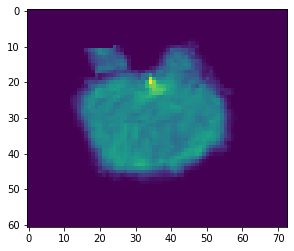

In [13]:
plt.imshow(x_train[15][48].T)

In [14]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 16
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
#    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

2022-05-04 17:32:33.343827: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 17:32:35.328597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9644 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:62:00.0, compute capability: 7.5


## 2. Model

### 2.1 Highest performing DFNN architecture from Mellema 2022 ** Best Performing with GAN data **

In [22]:
def Dense_model(width=61, height=73, depth=61):
    """Build a Highest performing Dense FNN neural network model from Mellema 2022."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Dense(6,kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.13)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Flatten()(x)
    

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

Model: "DFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 dense_4 (Dense)             (None, 61, 73, 61, 6)     12        
                                                                 
 dense_5 (Dense)             (None, 61, 73, 61, 64)    448       
                                                                 
 dropout_1 (Dropout)         (None, 61, 73, 61, 64)    0         
                                                                 
 dense_6 (Dense)             (None, 61, 73, 61, 64)    4160      
                                                                 
 flatten_1 (Flatten)         (None, 17384512)          0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1738451

In [23]:
# Compile model.
initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_DFNN.h5", save_best_only=True
#)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=10)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=early_stopping_cb,
)

Epoch 1/50
20/20 [==============================] - 4s 188ms/step - loss: 18524.4668 - binary_accuracy: 0.5897 - auc_1: 0.5799 - val_loss: 12698.7002 - val_binary_accuracy: 0.5714 - val_auc_1: 0.6842
Epoch 2/50
20/20 [==============================] - 4s 182ms/step - loss: 5507.1743 - binary_accuracy: 0.7276 - auc_1: 0.6974 - val_loss: 4978.2476 - val_binary_accuracy: 0.7905 - val_auc_1: 0.7964
Epoch 3/50
20/20 [==============================] - 4s 180ms/step - loss: 4974.9189 - binary_accuracy: 0.7468 - auc_1: 0.7148 - val_loss: 3003.1848 - val_binary_accuracy: 0.7905 - val_auc_1: 0.7902
Epoch 4/50
20/20 [==============================] - 4s 181ms/step - loss: 1587.8639 - binary_accuracy: 0.8045 - auc_1: 0.7804 - val_loss: 1428.8259 - val_binary_accuracy: 0.7905 - val_auc_1: 0.7328
Epoch 5/50
20/20 [==============================] - 4s 182ms/step - loss: 1020.3867 - binary_accuracy: 0.8429 - auc_1: 0.8169 - val_loss: 2121.9277 - val_binary_accuracy: 0.6667 - val_auc_1: 0.5724
Epoch 6/

In [25]:
# Save the weights
model.save_weights('DFNN_GAN_mod1.h5')

In [18]:
# # Load best weights.
model.load_weights("DFNN_GAN_mod1.h5")
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
print(prediction)
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
    "This model is %.2f percent confident that CT scan is %s"
    % ((100 * score), name))
print(y_test[0])

In [24]:
#proportion of training data that's positive
sum(y_train) / len(y_train)

#proportion of holdout data that's positive
(sum(y_val) / len(y_val))

#evaluate on the holdout data
model.evaluate(x_val, y_val)

3/3 [==============================] - 0s 79ms/step - loss: 1348.2887 - binary_accuracy: 0.8243 - auc_1: 0.8172


[1348.2886962890625, 0.8243243098258972, 0.817216157913208]

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

              precision    recall  f1-score   support

           0       0.78      0.89      0.83        35
           1       0.88      0.77      0.82        39

    accuracy                           0.82        74
   macro avg       0.83      0.83      0.82        74
weighted avg       0.83      0.82      0.82        74



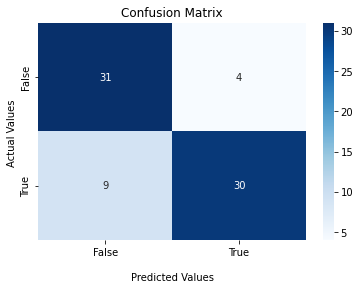

In [30]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

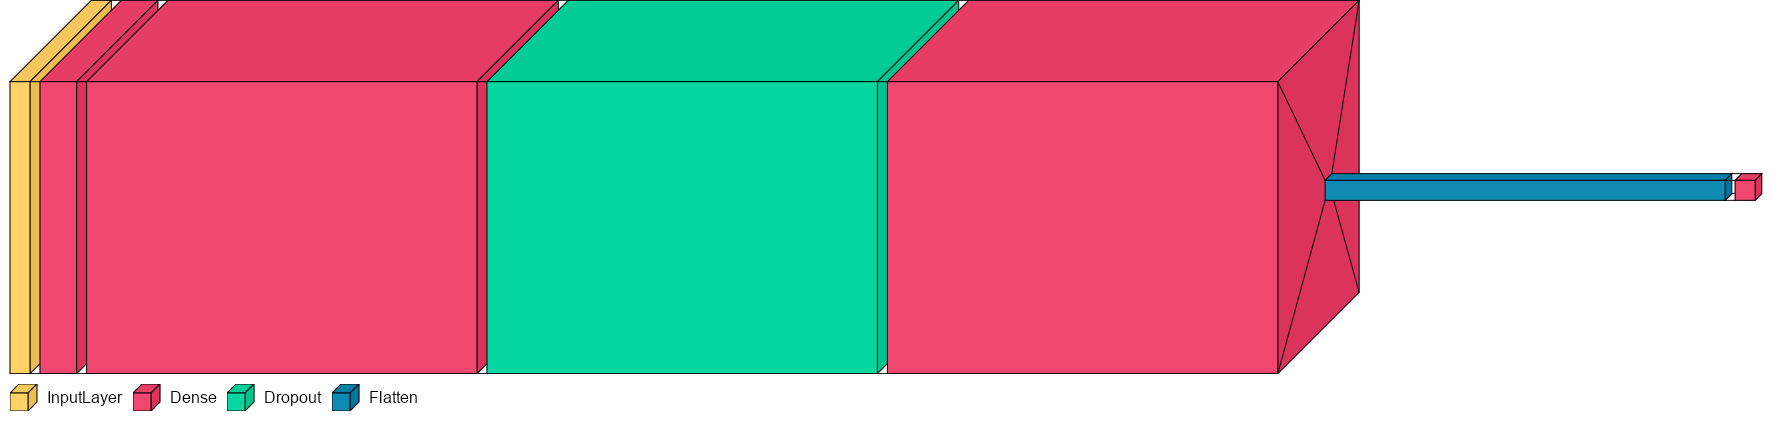

In [35]:
from PIL import ImageFont
font = ImageFont.truetype("Arial.ttf", 16)
visualkeras.layered_view(model, legend=True,font = font, to_file='DFNN1arch_gan.png')  # font is optional!

### 2.2 Build a Highest performing Dense FNN neural network model from Mellema 2022 with modifications

In [18]:
def Dense_model(width=61, height=73, depth=61):
    """Build a Highest performing Dense FNN neural network model from Mellema 2022 with modifications."""

    inputs = keras.Input((width, height, depth, 1))  
     
    x = layers.Dense(6,kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.13)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

Model: "DFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 dense_8 (Dense)             (None, 61, 73, 61, 6)     12        
                                                                 
 batch_normalization_2 (Batc  (None, 61, 73, 61, 6)    24        
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 61, 73, 61, 128)   896       
                                                                 
 dropout_2 (Dropout)         (None, 61, 73, 61, 128)   0         
                                                                 
 dense_10 (Dense)            (None, 61, 73, 61, 64)    8256      
                                                              

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.95, staircase=True)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_adamDFNN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=early_stopping_cb,
)

In [24]:
#evaluate on the holdout data
model.evaluate(x_val, y_val)

3/3 [==============================] - 0s 6ms/step - loss: 0.5729 - binary_accuracy: 0.6757 - auc_1: 0.6443


[0.5728657245635986, 0.6756756901741028, 0.6443223357200623]

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

              precision    recall  f1-score   support

           0       0.59      1.00      0.74        35
           1       1.00      0.38      0.56        39

    accuracy                           0.68        74
   macro avg       0.80      0.69      0.65        74
weighted avg       0.81      0.68      0.65        74



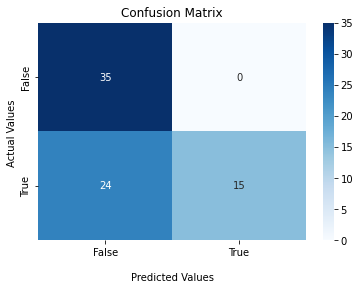

In [26]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### 2.3 Complex Highest performing Dense FNN neural network model from Mellema 2022 with modifications

In [32]:
def Dense_model(width=61, height=73, depth=61):
    """Build a complex Highest performing Dense FNN neural network model from Mellema 2022."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Dense(units=128, activation="relu", kernel_regularizer = keras.regularizers.L2(0.00011))(inputs)
    
    x = layers.BatchNormalization()(x)
    
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=42, activation="relu")(x)
    x = layers.Flatten()(x)
    
    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN_complex")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

Model: "DFNN_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 dense_13 (Dense)            (None, 61, 73, 61, 16)    32        
                                                                 
 dropout_5 (Dropout)         (None, 61, 73, 61, 16)    0         
                                                                 
 dense_14 (Dense)            (None, 61, 73, 61, 16)    272       
                                                                 
 flatten_3 (Flatten)         (None, 4346128)           0         
                                                                 
 dense_15 (Dense)            (None, 1)                 4346129   
                                                                 
Total params: 4,346,433
Trainable params: 4,346,433
Non

In [33]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_adamDFNN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/50
20/20 [==============================] - 2s 55ms/step - loss: 9955.9082 - binary_accuracy: 0.6795 - auc_3: 0.6706 - val_loss: 7681.6768 - val_binary_accuracy: 0.5619 - val_auc_3: 0.6754
Epoch 2/50
20/20 [==============================] - 1s 45ms/step - loss: 2862.1890 - binary_accuracy: 0.7372 - auc_3: 0.7381 - val_loss: 1085.7069 - val_binary_accuracy: 0.8000 - val_auc_3: 0.7961
Epoch 3/50
20/20 [==============================] - 1s 45ms/step - loss: 4904.7495 - binary_accuracy: 0.7308 - auc_3: 0.7385 - val_loss: 2590.1101 - val_binary_accuracy: 0.7905 - val_auc_3: 0.8004
Epoch 4/50
20/20 [==============================] - 1s 45ms/step - loss: 4504.1401 - binary_accuracy: 0.7276 - auc_3: 0.7149 - val_loss: 3547.4009 - val_binary_accuracy: 0.6571 - val_auc_3: 0.7599
Epoch 5/50
20/20 [==============================] - 1s 45ms/step - loss: 2785.5027 - binary_accuracy: 0.7532 - auc_3: 0.7668 - val_loss: 1749.1803 - val_binary_accuracy: 0.6857 - val_auc_3: 0.7796
Epoch 6/50
20/2

In [34]:
#evaluate on the holdout data
model.evaluate(x_val, y_val)

3/3 [==============================] - 0s 17ms/step - loss: 2446.7507 - binary_accuracy: 0.7703 - auc_3: 0.7773


[2446.750732421875, 0.7702702879905701, 0.7772893905639648]

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

              precision    recall  f1-score   support

           0       0.68      0.97      0.80        35
           1       0.96      0.59      0.73        39

    accuracy                           0.77        74
   macro avg       0.82      0.78      0.77        74
weighted avg       0.83      0.77      0.76        74



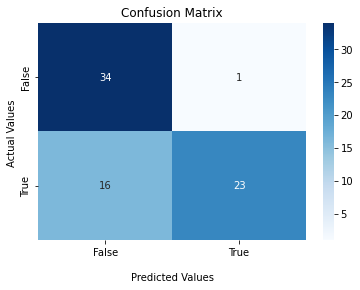

In [36]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()